# ProjF5 - Final Model
Use this document as a template to provide the evaluation of your final model. You are welcome to go in as much depth as needed.

Make sure you keep the sections specified in this template, but you are welcome to add more cells with your code or explanation as needed.

In [1]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import keras
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

### 1. Load and Prepare Data

This should illustrate your code for loading the dataset and the split into training, validation and testing. You can add steps like pre-processing if needed.

In [2]:
# Define a function for data augmentation by adding Gaussian noise
def add_gaussian_noise(data, mean=0, std_dev=0.005):
    """
    Add Gaussian noise to the input data.
    """
    noise = np.random.normal(mean, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

def scale_data(data, factors):
    """
    Scale the input data by applying different scaling factors.
    """
    scaled_data = data * factors[np.newaxis, :]
    return scaled_data

In [3]:

df_response = pd.read_excel('ResponseVariable.xlsx')
df_spectra = pd.read_csv('Spectra.csv')



df = pd.concat([df_response, df_spectra], axis=1)
df = df.iloc[:, 1:]
col = df.pop('Sample')
df.insert(0, col.name, col)
df.dropna(axis=0, how='any', inplace=True)  # Added inplace=True to drop NaN rows from df

X = df.iloc[:, 3:].values
y = df['Lignin'].values

### 2. Prepare your Final Model

Here you can have your code to either train (e.g., if you are building it from scratch) your model. These steps may require you to use other packages or python files. You can just call them here. You don't have to include them in your submission. Remember that we will be looking at the saved outputs in the notebooked and we will not run the entire notebook.

In [4]:


# Initialize KFold
kf = KFold(n_splits=5, shuffle=True)

# Lists to store results
test_losses = []
train_losses = []
histories = []  # To store training history for each fold

# Lists to store training and validation loss for each fold
train_loss_per_fold = []
val_loss_per_fold = []

# Train the model in each fold
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]

    # Data Augmentation: Adding Gaussian noise
    X_train_augmented_1 = add_gaussian_noise(X_train, mean=0, std_dev=0.005)
    X_train_augmented_2 = add_gaussian_noise(X_train, mean=0, std_dev=0.006)
    X_train_augmented_3 = add_gaussian_noise(X_train, mean=0, std_dev=0.007)
    X_train_augmented_4 = add_gaussian_noise(X_train, mean=0, std_dev=0.008)
    X_train_augmented_5 = add_gaussian_noise(X_train, mean=0, std_dev=0.009)

    # Data Augmentation: Scaling on noisy data
    scaling_factors = np.random.uniform(0.97, 1.03, size=(X_train_augmented_1.shape[1],))
    X_train_scaled_1 = scale_data(X_train_augmented_1, scaling_factors)
    X_train_scaled_2 = scale_data(X_train_augmented_2, scaling_factors)
    X_train_scaled_3 = scale_data(X_train_augmented_3, scaling_factors)
    X_train_scaled_4 = scale_data(X_train_augmented_4, scaling_factors)
    X_train_scaled_5 = scale_data(X_train_augmented_5, scaling_factors)

    # Combine augmented data
    X_train_combined = np.concatenate((X_train, X_train_augmented_1, X_train_augmented_2, X_train_scaled_1,
                                       X_train_scaled_2), axis=0)

    y_train_combined = np.concatenate((y_train, y_train, y_train, y_train, y_train), axis=0)

    # Normalization
    scaler = StandardScaler()
    X_train_combined_scaled = scaler.fit_transform(X_train_combined)
    X_val_scaled = scaler.transform(X_val)

    # Create and compile the model
    model = Sequential()

    # Convolutional layers
    model.add(Conv1D(filters=32, kernel_size=20, strides=1, input_shape=(700, 1)))
    model.add(keras.layers.LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=5, padding='valid'))

    model.add(Conv1D(filters=64, kernel_size=10, strides=1))
    model.add(keras.layers.LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=5, padding='valid'))

    model.add(Conv1D(filters=128, kernel_size=5, strides=1))
    model.add(keras.layers.LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, padding='valid'))

    # Flatten layer to convert 3D feature maps to 1D feature vectors
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(32))
    model.add(keras.layers.LeakyReLU())
    model.add(BatchNormalization())

    model.add(Dense(64))
    model.add(keras.layers.LeakyReLU())
    model.add(BatchNormalization())

    model.add(Dense(1, activation='linear'))  # Output layer with linear activation for regression

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)

    # Fit the model
    history = model.fit(X_train_combined_scaled, y_train_combined,
                        epochs=300,
                        batch_size=32,
                        validation_data=(X_val_scaled, y_val),
                        callbacks=[early_stopping],
                        verbose=1)

    # Store training history
    histories.append(history)

    # Evaluate the model
    train_loss, _ = model.evaluate(X_train_combined_scaled, y_train_combined, verbose=0)
    val_loss, _ = model.evaluate(X_val_scaled, y_val, verbose=0)
    train_loss_per_fold.append(train_loss)
    val_loss_per_fold.append(val_loss)

    print(f"Fold {fold+1}: Train Loss: {train_loss}, Validation Loss: {val_loss}")



C:\Users\alire\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 675.2039 - mse: 675.2039 - val_loss: 652.9148 - val_mse: 652.9148
Epoch 2/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 621.4109 - mse: 621.4109 - val_loss: 551.6447 - val_mse: 551.6447
Epoch 3/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 513.1323 - mse: 513.1323 - val_loss: 395.3691 - val_mse: 395.3691
Epoch 4/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 365.4751 - mse: 365.4751 - val_loss: 278.1109 - val_mse: 278.1109
Epoch 5/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 222.9821 - mse: 222.9821 - val_loss: 155.8780 - val_mse: 155.8780
Epoch 6/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 114.5672 - mse: 114.5672 - val_loss: 63.6733 - val_mse: 63.6733
Epoch 7/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 45.1026 - mse: 45.1026 - val_loss: 25.7394 - val_mse: 25.7394
Epoch 8/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 14.4021 - mse: 14.4021 - val_loss: 9.3663 - val_mse: 9.3663
Epoc

C:\Users\alire\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 683.8793 - mse: 683.8793 - val_loss: 626.4719 - val_mse: 626.4719
Epoch 2/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 617.6093 - mse: 617.6093 - val_loss: 535.9067 - val_mse: 535.9067
Epoch 3/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 503.2038 - mse: 503.2038 - val_loss: 400.1578 - val_mse: 400.1578
Epoch 4/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 364.7038 - mse: 364.7038 - val_loss: 258.5734 - val_mse: 258.5734
Epoch 5/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 221.4009 - mse: 221.4009 - val_loss: 145.1769 - val_mse: 145.1769
Epoch 6/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 112.1088 - mse: 112.1088 - val_loss: 60.4440 - val_mse: 60.4440
Epoch 7/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 45.0026 - mse: 45.0026 - val_loss: 23.9435 - val_mse: 23.9435
Epoch 8/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 14.9465 - mse: 14.9465 - val_loss: 7.5045 - val_mse: 7.5045
Epoc

C:\Users\alire\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 678.4314 - mse: 678.4314 - val_loss: 652.8224 - val_mse: 652.8224
Epoch 2/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 620.8763 - mse: 620.8763 - val_loss: 563.0599 - val_mse: 563.0599
Epoch 3/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 505.2885 - mse: 505.2885 - val_loss: 433.0960 - val_mse: 433.0960
Epoch 4/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 365.4025 - mse: 365.4025 - val_loss: 263.3349 - val_mse: 263.3349
Epoch 5/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 223.9723 - mse: 223.9723 - val_loss: 125.3624 - val_mse: 125.3624
Epoch 6/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 112.4581 - mse: 112.4581 - val_loss: 51.3604 - val_mse: 51.3604
Epoch 7/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 44.4292 - mse: 44.4292 - val_loss: 17.8704 - val_mse: 17.8704
Epoch 8/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 14.0001 - mse: 14.0001 - val_loss: 6.3461 - val_mse: 6.3461
Epoc

C:\Users\alire\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 675.8828 - mse: 675.8828 - val_loss: 637.8260 - val_mse: 637.8260
Epoch 2/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 614.6318 - mse: 614.6318 - val_loss: 537.0864 - val_mse: 537.0864
Epoch 3/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 502.5294 - mse: 502.5294 - val_loss: 392.9366 - val_mse: 392.9366
Epoch 4/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 360.1781 - mse: 360.1781 - val_loss: 255.3698 - val_mse: 255.3698
Epoch 5/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 218.3331 - mse: 218.3331 - val_loss: 129.4601 - val_mse: 129.4601
Epoch 6/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 107.4138 - mse: 107.4138 - val_loss: 54.0348 - val_mse: 54.0348
Epoch 7/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 43.0871 - mse: 43.0871 - val_loss: 18.3432 - val_mse: 18.3432
Epoch 8/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 13.5102 - mse: 13.5102 - val_loss: 4.4857 - val_mse: 4.4857
Epoc

C:\Users\alire\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 679.5054 - mse: 679.5054 - val_loss: 620.7325 - val_mse: 620.7325
Epoch 2/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 624.3359 - mse: 624.3359 - val_loss: 532.4789 - val_mse: 532.4789
Epoch 3/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 515.0267 - mse: 515.0267 - val_loss: 389.4563 - val_mse: 389.4563
Epoch 4/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 374.0951 - mse: 374.0951 - val_loss: 226.4883 - val_mse: 226.4883
Epoch 5/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 229.8092 - mse: 229.8092 - val_loss: 119.4721 - val_mse: 119.4721
Epoch 6/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 116.2144 - mse: 116.2144 - val_loss: 44.9163 - val_mse: 44.9163
Epoch 7/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 46.1150 - mse: 46.1150 - val_loss: 12.5363 - val_mse: 12.5363
Epoch 8/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 15.1638 - mse: 15.1638 - val_loss: 3.2604 - val_mse: 3.2604
Epo

### 3. Model Performance

Make sure to include the following:
- Performance on the training set
- Performance on the test set
- Provide some screenshots of your output (e.g., pictures, text output, or a histogram of predicted values in the case of tabular data). Any visualization of the predictions are welcome.

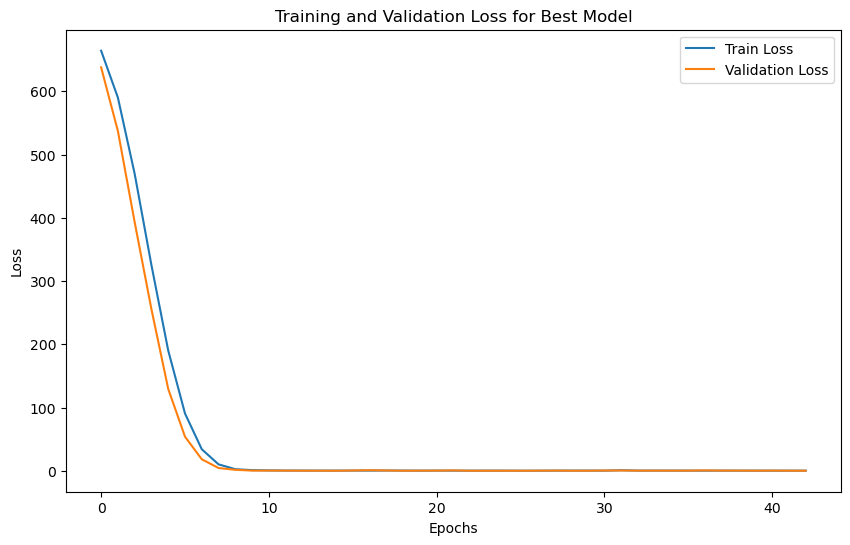

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
R^2 Score: 0.9265259152518237


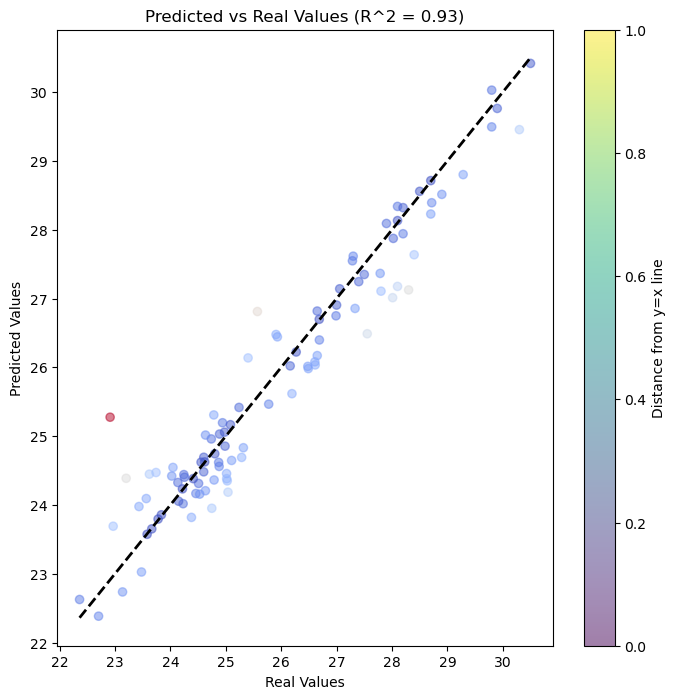

In [5]:
# Select the model with the lowest validation loss
best_fold_index = np.argmin(val_loss_per_fold)
best_model = model

# Plot training and validation loss for the best model
plt.figure(figsize=(10, 6))
plt.plot(histories[best_fold_index].history['loss'], label='Train Loss')
plt.plot(histories[best_fold_index].history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Best Model')
plt.legend()
plt.show()



# Predict on test data using the best model
X_test_scaled = scaler.transform(X[test_index])
y_pred = best_model.predict(X_test_scaled)

r2 = r2_score(y[test_index], y_pred)
print("R^2 Score:", r2)

# Calculate absolute difference between predicted and true values
abs_diff = abs(y[test_index] - y_pred.flatten())

# Define colors based on absolute difference
max_abs_diff = max(abs_diff)
colors = plt.cm.coolwarm(abs_diff / max_abs_diff)  # Normalize absolute difference and map to coolwarm colormap

# Plot predicted values versus real values with heatmap
plt.figure(figsize=(8, 8))
plt.scatter(y[test_index], y_pred, c=colors, alpha=0.5)
plt.plot([y[test_index].min(), y[test_index].max()], [y[test_index].min(), y[test_index].max()], 'k--', lw=2)  # y=x line
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Real Values (R^2 = {:.2f})'.format(r2))
plt.colorbar(label='Distance from y=x line')
plt.show()


### 3. Model Performance

Make sure to include the following:
- Performance on the training set
- Performance on the test set
- Provide some screenshots of your output (e.g., pictures, text output, or a histogram of predicted values in the case of tabular data). Any visualization of the predictions are welcome.

# Feature Selection
In this section we try to find the minimum number of wavelenghts that give us the same results by fitting a random forest regressor and find the most contributing wavelenths of the spectra.

In [6]:
#Fit a random forest regressor to determine feature importances
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_
print(feature_importances)
# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
print(sorted_indices)
# Select top N features (e.g., top 100)


[2.43630491e-03 1.43660842e-03 1.84281015e-03 2.24390451e-03
 1.50581205e-03 8.94926605e-04 1.01733019e-03 6.77394915e-04
 6.47729875e-04 6.36572207e-04 8.69897662e-04 7.60511950e-04
 5.10897679e-04 5.55020301e-04 8.93753751e-04 5.70334077e-04
 9.86277882e-04 7.14004454e-04 7.24593679e-04 1.04407267e-03
 1.02409897e-03 8.85069848e-04 5.98035111e-04 6.67332418e-04
 5.01472850e-04 4.82422757e-04 5.46257098e-04 3.87304198e-04
 5.11203305e-04 4.63465047e-04 4.72232785e-04 3.27313834e-04
 4.71108994e-04 2.28242763e-04 3.23655877e-04 2.96859181e-04
 2.79728464e-04 3.06136265e-04 4.46687297e-04 4.86134243e-04
 2.53005191e-04 2.32759556e-04 4.95046589e-04 3.74840865e-04
 3.15553074e-04 4.71160545e-04 2.19282385e-04 3.66840989e-04
 2.51229653e-04 1.58941222e-04 2.26587210e-04 1.78297167e-04
 3.32550685e-04 3.37067061e-04 2.72458894e-04 2.67806702e-04
 1.31957711e-03 3.45702742e-04 4.01086736e-04 1.08470926e-03
 1.54164988e-03 2.29128677e-03 2.13594234e-03 1.50170918e-03
 2.47511236e-03 2.693191

In [7]:
all_val_loss = []
all_r2_scores = []
all_y_preds = []
all_indices = []
minimum_num_feat = [100, 200, 300, 400, 500, 600, 700]


for i in minimum_num_feat:
    selected_indices = sorted_indices[:i]
   # selected_indices
    selected_indices.sort()
    #selected_indices
    all_indices.append(selected_indices)
    
    X_new = X[:, selected_indices]
    
    X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(X_new, y, test_size=0.2, random_state=42)
    
    
    X_train_augmented_1 = add_gaussian_noise(X_train_feat, mean=0, std_dev=0.005)
    X_train_augmented_2 = add_gaussian_noise(X_train_feat, mean=0, std_dev=0.006)
    scaling_factors = np.random.uniform(0.97, 1.03, size=(X_train_augmented_1.shape[1],))
    X_train_scaled_1 = scale_data(X_train_augmented_1, scaling_factors)
    X_train_scaled_2 = scale_data(X_train_augmented_2, scaling_factors)

    X_train_combined = np.concatenate((X_train_feat, X_train_augmented_1, X_train_augmented_2, X_train_scaled_1,
                                           X_train_scaled_2), axis=0)

    y_train_combined = np.concatenate((y_train_feat, y_train_feat, y_train_feat, y_train_feat, y_train_feat), axis=0)

    
    X_train_combined_scaled = scaler.fit_transform(X_train_combined)
    X_test_scaled = scaler.transform(X_test_feat)
    
    





    # Reshape data for input to the model
    #X_train_selected = X_train_selected.reshape(X_train_selected.shape[0], X_train_selected.shape[1], 1)
    #X_val_selected = X_val_selected.reshape(X_val_selected.shape[0], X_val_selected.shape[1], 1)
    #X_test_selected = X_test_selected.reshape(X_test_selected.shape[0], X_test_selected.shape[1], 1)

    # Define and compile the model with reduced features
    model_selected = Sequential()

    # Convolutional layers
    model_selected.add(Conv1D(filters=32, kernel_size=10, strides=1, input_shape=(X_train_combined_scaled.shape[1], 1)))
    model_selected.add(keras.layers.LeakyReLU())
    model_selected.add(BatchNormalization())
    model_selected.add(MaxPooling1D(pool_size=2, padding='valid'))

    model_selected.add(Conv1D(filters=64, kernel_size=5, strides=1))
    model_selected.add(keras.layers.LeakyReLU())
    model_selected.add(BatchNormalization())
    model_selected.add(MaxPooling1D(pool_size=2, padding='valid'))

    model_selected.add(Conv1D(filters=128, kernel_size=3, strides=1))
    model_selected.add(keras.layers.LeakyReLU())
    model_selected.add(BatchNormalization())
    model_selected.add(MaxPooling1D(pool_size=2, padding='valid'))

    # Flatten layer to convert 3D feature maps to 1D feature vectors
    model_selected.add(Flatten())

    # Fully connected layers
    model_selected.add(Dense(32))
    model_selected.add(keras.layers.LeakyReLU())
    model_selected.add(BatchNormalization())

    model_selected.add(Dense(64))
    model_selected.add(keras.layers.LeakyReLU())
    model_selected.add(BatchNormalization())

    model_selected.add(Dense(1, activation='linear'))  # Output layer with linear activation for regression
    early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20, restore_best_weights = True)
    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model_selected.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

    # Fit the model with selected features
    history_selected = model_selected.fit(X_train_combined_scaled, y_train_combined,
                                          epochs=100,
                                          batch_size=32, validation_data=(X_test_scaled, y_test_feat),
                                          callbacks=[early_stopping],
                                          verbose=1)

    
    val_loss_selected, _ = model_selected.evaluate(X_test_scaled, y_test_feat, verbose=1)
    #print("Validation Loss with selected features:", val_loss_selected)
    all_val_loss.append(val_loss_selected)
    # Predict on test data using the model with selected features
    y_pred_selected = model_selected.predict(X_test_scaled)
    all_y_preds.append(y_pred_selected)
    r2_selected = r2_score(y_test_feat, y_pred_selected)
    #print("R^2 Score with selected features:", r2_selected)
    all_r2_scores.append(r2_selected)


C:\Users\alire\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 675.2658 - mse: 675.2658 - val_loss: 635.6551 - val_mse: 635.6551
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 616.6372 - mse: 616.6372 - val_loss: 539.5750 - val_mse: 539.5750
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 505.1858 - mse: 505.1858 - val_loss: 410.3333 - val_mse: 410.3333
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 365.4068 - mse: 365.4068 - val_loss: 247.1829 - val_mse: 247.1829
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 219.8541 - mse: 219.8541 - val_loss: 118.1651 - val_mse: 118.1651
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 110.6431 - mse: 110.6431 - val_loss: 57.8559 - val_mse: 57.8559
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 44.3140 - mse: 44.3140 - val_loss: 20.0232 - val_mse: 20.0232
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 13.8819 - mse: 13.8819 - val_loss: 6.7645 - val_mse: 6.7645
Epoc

C:\Users\alire\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 672.3903 - mse: 672.3903 - val_loss: 648.2758 - val_mse: 648.2758
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 609.2859 - mse: 609.2859 - val_loss: 535.5600 - val_mse: 535.5600
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 501.5753 - mse: 501.5753 - val_loss: 378.1472 - val_mse: 378.1472
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 357.3855 - mse: 357.3855 - val_loss: 228.0073 - val_mse: 228.0073
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 217.6860 - mse: 217.6860 - val_loss: 105.3508 - val_mse: 105.3508
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 110.0285 - mse: 110.0285 - val_loss: 55.6949 - val_mse: 55.6949
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 44.2686 - mse: 44.2686 - val_loss: 17.2160 - val_mse: 17.2160
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 14.4808 - mse: 14.4808 - val_loss: 4.0316 - val_mse: 4.0316
Epoc

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


C:\Users\alire\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 672.9056 - mse: 672.9056 - val_loss: 637.9276 - val_mse: 637.9276
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 614.2774 - mse: 614.2774 - val_loss: 539.8840 - val_mse: 539.8840
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 502.0294 - mse: 502.0294 - val_loss: 395.5821 - val_mse: 395.5821
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 362.9604 - mse: 362.9604 - val_loss: 247.4942 - val_mse: 247.4942
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 220.1024 - mse: 220.1024 - val_loss: 122.1235 - val_mse: 122.1235
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 110.6777 - mse: 110.6777 - val_loss: 53.7163 - val_mse: 53.7163
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 43.4494 - mse: 43.4494 - val_loss: 15.3562 - val_mse: 15.3562
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 13.6883 - mse: 13.6883 - val_loss: 4.4673 - val_mse: 4.4673
Epoc

C:\Users\alire\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 677.1078 - mse: 677.1078 - val_loss: 645.5350 - val_mse: 645.5350
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 614.1021 - mse: 614.1021 - val_loss: 524.1744 - val_mse: 524.1744
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 501.4800 - mse: 501.4800 - val_loss: 400.6702 - val_mse: 400.6702
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 364.0432 - mse: 364.0432 - val_loss: 271.1846 - val_mse: 271.1846
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 226.1096 - mse: 226.1096 - val_loss: 165.7652 - val_mse: 165.7652
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 114.1306 - mse: 114.1306 - val_loss: 66.4137 - val_mse: 66.4137
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 44.9734 - mse: 44.9734 - val_loss: 23.4541 - val_mse: 23.4541
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 14.1946 - mse: 14.1946 - val_loss: 8.5484 - val_mse: 8.5484
Epoc

C:\Users\alire\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 674.2757 - mse: 674.2757 - val_loss: 645.8016 - val_mse: 645.8016
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 612.6025 - mse: 612.6025 - val_loss: 551.5319 - val_mse: 551.5319
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 502.5147 - mse: 502.5147 - val_loss: 399.7836 - val_mse: 399.7836
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 361.5241 - mse: 361.5241 - val_loss: 251.7254 - val_mse: 251.7254
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 221.7286 - mse: 221.7286 - val_loss: 137.7888 - val_mse: 137.7888
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 111.7010 - mse: 111.7010 - val_loss: 50.4743 - val_mse: 50.4743
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 43.5934 - mse: 43.5934 - val_loss: 18.8357 - val_mse: 18.8357
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 13.4559 - mse: 13.4559 - val_loss: 7.7078 - val_mse: 7.7078
Epoc

C:\Users\alire\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 675.7758 - mse: 675.7758 - val_loss: 646.4474 - val_mse: 646.4474
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 617.0701 - mse: 617.0701 - val_loss: 529.0280 - val_mse: 529.0280
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 510.5806 - mse: 510.5806 - val_loss: 396.1511 - val_mse: 396.1511
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 366.6592 - mse: 366.6592 - val_loss: 243.0829 - val_mse: 243.0829
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 227.2439 - mse: 227.2439 - val_loss: 139.5364 - val_mse: 139.5364
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 115.0954 - mse: 115.0954 - val_loss: 59.5079 - val_mse: 59.5079
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 45.1626 - mse: 45.1626 - val_loss: 19.6847 - val_mse: 19.6847
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 14.8002 - mse: 14.8002 - val_loss: 7.7852 - val_mse: 7.7852
Epoc

C:\Users\alire\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 673.6452 - mse: 673.6452 - val_loss: 665.6671 - val_mse: 665.6671
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 618.6535 - mse: 618.6535 - val_loss: 559.7867 - val_mse: 559.7867
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 514.0703 - mse: 514.0703 - val_loss: 422.4541 - val_mse: 422.4541
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 365.3263 - mse: 365.3263 - val_loss: 261.2998 - val_mse: 261.2998
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 226.0541 - mse: 226.0541 - val_loss: 144.0051 - val_mse: 144.0051
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 115.6238 - mse: 115.6238 - val_loss: 65.1892 - val_mse: 65.1892
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 46.1133 - mse: 46.1133 - val_loss: 18.8022 - val_mse: 18.8022
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 14.1392 - mse: 14.1392 - val_loss: 3.6095 - val_mse: 3.6095
Epoc

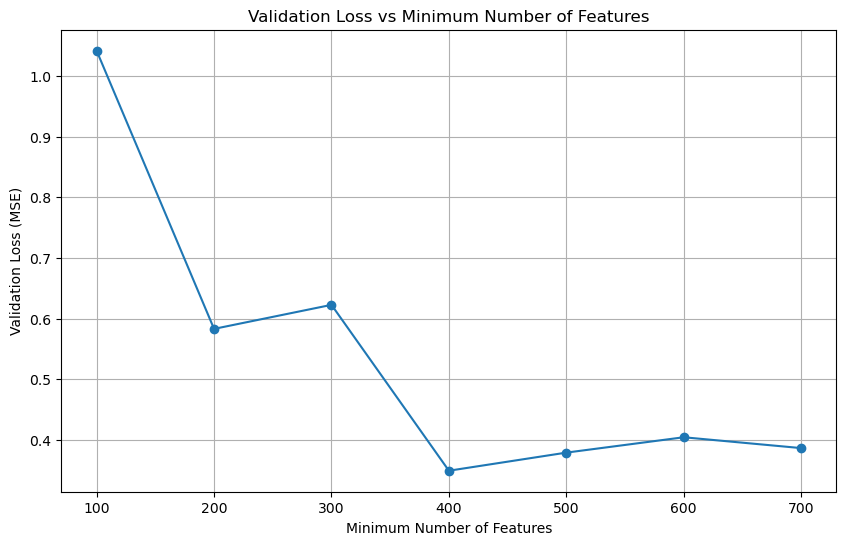

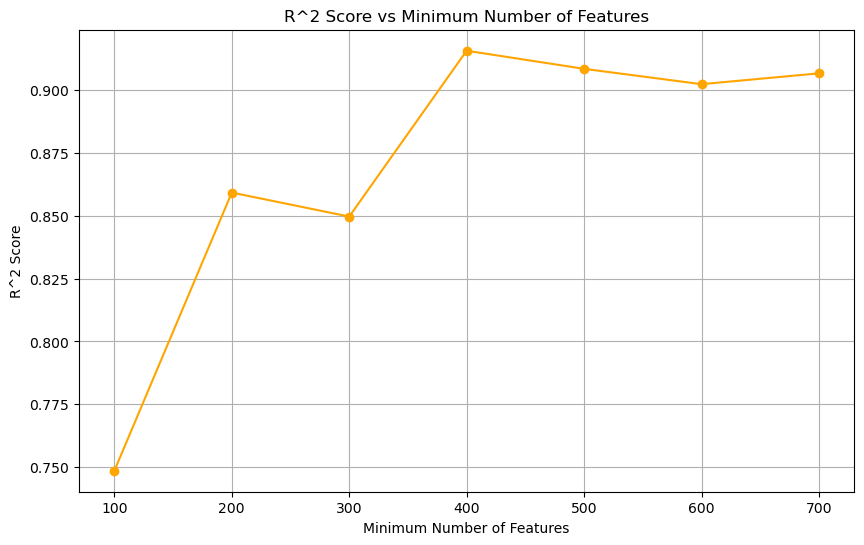

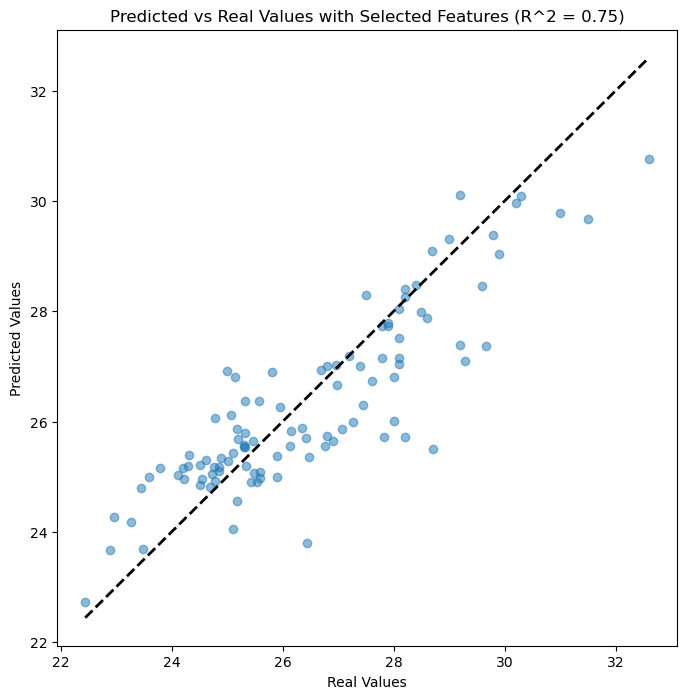

In [13]:
# Plot validation loss versus minimum number of features
plt.figure(figsize=(10, 6))
plt.plot(minimum_num_feat, all_val_loss, marker='o')
plt.title('Validation Loss vs Minimum Number of Features')
plt.xlabel('Minimum Number of Features')
plt.ylabel('Validation Loss (MSE)')
plt.grid(True)
plt.show()

# Plot R^2 scores versus minimum number of features
plt.figure(figsize=(10, 6))
plt.plot(minimum_num_feat, all_r2_scores, marker='o', color='orange')
plt.title('R^2 Score vs Minimum Number of Features')
plt.xlabel('Minimum Number of Features')
plt.ylabel('R^2 Score')
plt.grid(True)
plt.show()

# Find the index of the minimum validation loss
min_r2_index = np.argmin(all_r2_scores)

# Plot predicted values versus real values with heatmap for the model with minimum val loss
y_pred_min_r2 = all_y_preds[min_r2_index]
plt.figure(figsize=(8, 8))
plt.scatter(y_test_feat, y_pred_min_r2, alpha=0.5)
plt.plot([y_test_feat.min(), y_test_feat.max()], [y_test_feat.min(), y_test_feat.max()], 'k--', lw=2)  # y=x line
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Real Values with Selected Features (R^2 = {:.2f})'.format(all_r2_scores[min_r2_index]))

plt.show()